<a href="https://colab.research.google.com/github/likarajo/ResNetX/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model(
  (stem): Stem(
    (conv_3x3): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (body): Sequential(
    (0): Layer(
      (layers): Sequential(
        (0): XBlock(
          (conv1_1x1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2_3x3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (downsample): Downsample(
            (conv_1x1): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (conv3_1x1): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=Fal

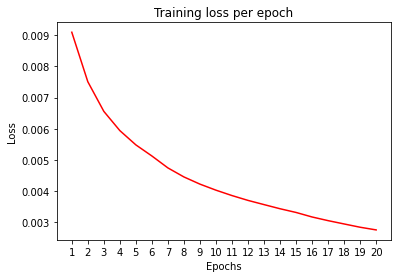

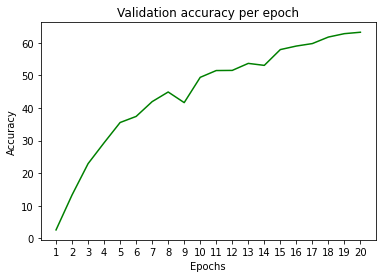

Testing...
Accuracy of test set = 63.19

Class accuracy:
Accuracy of plane = 84.00
Accuracy of car   = 66.00
Accuracy of bird  = 64.00
Accuracy of cat   = 64.00
Accuracy of deer  = 56.00
Accuracy of dog   = 46.00
Accuracy of frog  = 56.00
Accuracy of horse = 44.00
Accuracy of ship  = 92.00
Accuracy of truck = 66.00


In [1]:
################################################################################
#
# LOGISTICS
#
#    Rajarshi Chattopadhyay
#    RXC170010
#
# DESCRIPTION
#
#    Image classification in PyTorch for ImageNet reduced to 100 classes and
#    down sampled such that the short side is 64 pixels and the long side is
#    >= 64 pixels
#
#    This script achieved a best accuracy of 63.56% on epoch 39 with a learning
#    rate at that point of 0.00001 and time required for each epoch of ~ 179s.
#    Also, there is no significant increase in the accuracy after epoch 20. 
#
# INSTRUCTIONS
#
#    1. Go to Google Colaboratory: https://colab.research.google.com/notebooks/welcome.ipynb
#    2. File - New Python 3 notebook
#    3. Cut and paste this file into the cell (feel free to divide into multiple cells)
#    4. Runtime - Run all
#
# NOTES
#
#    0. For a mapping of category names to directory names see:
#       https://gist.github.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57
#
#    1. The original 2012 ImageNet images are down sampled such that their short
#       side is 64 pixels (the other side is >= 64 pixels) and only 100 of the
#       original 1000 classes are kept.
#
#    2. Build and train a RegNetX image classifier modified as follows:
#
#       - Set stride = 1 (instead of stride = 2) in the stem
#       - Replace the first stride = 2 down sampling building block in the
#         original network by a stride = 1 normal building block
#       - The fully connected layer in the decoder outputs 100 classes instead
#         of 1000 classes
#
#       The original RegNetX takes in 3x224x224 input images and generates Nx7x7
#       feature maps before the decoder, this modified RegNetX will take in
#       3x56x56 input images and generate Nx7x7 feature maps before the decoder.
#       For reference, an implementation of this network took ~ 112 s per epoch
#       for training, validation and checkpoint saving on Sep 27, 2020 using a
#       free GPU runtime in Google Colab.
#
################################################################################

################################################################################
#
# IMPORT
#
################################################################################

# torch
import torch
import torch.nn       as     nn
import torch.optim    as     optim
from   torch.autograd import Function

# torch utils
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

# additional libraries
import os
import urllib.request
import zipfile
import time
import math
import numpy             as np
import matplotlib.pyplot as plt

################################################################################
#
# PARAMETERS
#
################################################################################

# data
DATA_DIR_1        = 'data'
DATA_DIR_2        = 'data/imagenet64'
DATA_DIR_TRAIN    = 'data/imagenet64/train'
DATA_DIR_TEST     = 'data/imagenet64/val'
DATA_FILE_TRAIN_1 = 'Train1.zip'
DATA_FILE_TRAIN_2 = 'Train2.zip'
DATA_FILE_TRAIN_3 = 'Train3.zip'
DATA_FILE_TRAIN_4 = 'Train4.zip'
DATA_FILE_TRAIN_5 = 'Train5.zip'
DATA_FILE_TEST_1  = 'Val1.zip'
DATA_URL_TRAIN_1  = 'https://github.com/arthurredfern/UT-Dallas-CS-6301-CNNs/raw/master/Data/Train1.zip'
DATA_URL_TRAIN_2  = 'https://github.com/arthurredfern/UT-Dallas-CS-6301-CNNs/raw/master/Data/Train2.zip'
DATA_URL_TRAIN_3  = 'https://github.com/arthurredfern/UT-Dallas-CS-6301-CNNs/raw/master/Data/Train3.zip'
DATA_URL_TRAIN_4  = 'https://github.com/arthurredfern/UT-Dallas-CS-6301-CNNs/raw/master/Data/Train4.zip'
DATA_URL_TRAIN_5  = 'https://github.com/arthurredfern/UT-Dallas-CS-6301-CNNs/raw/master/Data/Train5.zip'
DATA_URL_TEST_1   = 'https://github.com/arthurredfern/UT-Dallas-CS-6301-CNNs/raw/master/Data/Val1.zip'
DATA_BATCH_SIZE   = 512
DATA_NUM_WORKERS  = 4
DATA_NUM_CHANNELS = 3
DATA_NUM_CLASSES  = 100
DATA_RESIZE       = 64
DATA_CROP         = 56
DATA_MEAN         = (0.485, 0.456, 0.406)
DATA_STD_DEV      = (0.229, 0.224, 0.225)
DATA_CLASS_NAMES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# model
NETWORK_DEPTH = 13
INITIAL_WIDTH = 24
SLOPE = 36
QUANTIZATION = 2.5
BOTTLENECK_RATIO = 1
GROUP_WIDTH = 8

# training
TRAINING_LR_MAX          = 0.001
TRAINING_LR_INIT_SCALE   = 0.01
TRAINING_LR_INIT_EPOCHS  = 5
TRAINING_LR_FINAL_SCALE  = 0.01
TRAINING_LR_FINAL_EPOCHS = 15
#TRAINING_LR_FINAL_EPOCHS = 2 # uncomment for a quick test
TRAINING_NUM_EPOCHS      = TRAINING_LR_INIT_EPOCHS + TRAINING_LR_FINAL_EPOCHS
TRAINING_LR_INIT         = TRAINING_LR_MAX*TRAINING_LR_INIT_SCALE
TRAINING_LR_FINAL        = TRAINING_LR_MAX*TRAINING_LR_FINAL_SCALE

# file
FILE_NAME = 'ResNetX.pt'
FILE_SAVE = 0
FILE_LOAD = 0

################################################################################
#
# DATA
#
################################################################################

# create a local directory structure for data storage
if (os.path.exists(DATA_DIR_1) == False):
    os.mkdir(DATA_DIR_1)
if (os.path.exists(DATA_DIR_2) == False):
    os.mkdir(DATA_DIR_2)
if (os.path.exists(DATA_DIR_TRAIN) == False):
    os.mkdir(DATA_DIR_TRAIN)
if (os.path.exists(DATA_DIR_TEST) == False):
    os.mkdir(DATA_DIR_TEST)

# download data
if (os.path.exists(DATA_FILE_TRAIN_1) == False):
    urllib.request.urlretrieve(DATA_URL_TRAIN_1, DATA_FILE_TRAIN_1)
if (os.path.exists(DATA_FILE_TRAIN_2) == False):
    urllib.request.urlretrieve(DATA_URL_TRAIN_2, DATA_FILE_TRAIN_2)
if (os.path.exists(DATA_FILE_TRAIN_3) == False):
    urllib.request.urlretrieve(DATA_URL_TRAIN_3, DATA_FILE_TRAIN_3)
if (os.path.exists(DATA_FILE_TRAIN_4) == False):
    urllib.request.urlretrieve(DATA_URL_TRAIN_4, DATA_FILE_TRAIN_4)
if (os.path.exists(DATA_FILE_TRAIN_5) == False):
    urllib.request.urlretrieve(DATA_URL_TRAIN_5, DATA_FILE_TRAIN_5)
if (os.path.exists(DATA_FILE_TEST_1) == False):
    urllib.request.urlretrieve(DATA_URL_TEST_1, DATA_FILE_TEST_1)

# extract data
with zipfile.ZipFile(DATA_FILE_TRAIN_1, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR_TRAIN)
with zipfile.ZipFile(DATA_FILE_TRAIN_2, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR_TRAIN)
with zipfile.ZipFile(DATA_FILE_TRAIN_3, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR_TRAIN)
with zipfile.ZipFile(DATA_FILE_TRAIN_4, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR_TRAIN)
with zipfile.ZipFile(DATA_FILE_TRAIN_5, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR_TRAIN)
with zipfile.ZipFile(DATA_FILE_TEST_1, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR_TEST)

# transforms
transform_train = transforms.Compose([transforms.RandomResizedCrop(DATA_CROP), transforms.RandomHorizontalFlip(p=0.5), transforms.ToTensor(), transforms.Normalize(DATA_MEAN, DATA_STD_DEV)])
transform_test  = transforms.Compose([transforms.Resize(DATA_RESIZE), transforms.CenterCrop(DATA_CROP), transforms.ToTensor(), transforms.Normalize(DATA_MEAN, DATA_STD_DEV)])

# data sets
dataset_train = torchvision.datasets.ImageFolder(DATA_DIR_TRAIN, transform=transform_train)
dataset_test  = torchvision.datasets.ImageFolder(DATA_DIR_TEST,  transform=transform_test)

# data loader
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=DATA_BATCH_SIZE, shuffle=True,  num_workers=DATA_NUM_WORKERS, pin_memory=True, drop_last=True)
dataloader_test  = torch.utils.data.DataLoader(dataset_test,  batch_size=DATA_BATCH_SIZE, shuffle=False, num_workers=DATA_NUM_WORKERS, pin_memory=True, drop_last=True)

################################################################################
#
# NETWORK BUILDING BLOCK
#
################################################################################

# Downsample
class Downsample(nn.Module):

    # initialization
    def __init__(self, Ni, No, stride):

        # parent initialization
        super(Downsample, self).__init__()

        self.conv_1x1 = nn.Conv2d(Ni, No, kernel_size=1, stride=stride, bias=False)
        self.bn = nn.BatchNorm2d(No)

    # forward path
    def forward(self, x):

        y = self.bn(self.conv_1x1(x))

        return y

# Stem
class Stem(nn.Module):

    # initialization
    def __init__(self, No, Ni=3):

        # parent initialization
        super(Stem, self).__init__()

        self.conv_3x3 = nn.Conv2d(Ni, No, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(No)

    # forward path
    def forward(self, x):

        y = nn.functional.relu(self.bn(self.conv_3x3(x)))

        return y

# Head
class Head(nn.Module):

    # initialization
    def __init__(self, Ni, classes):

        # parent initialization
        super(Head, self).__init__()

        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.f_out = nn.Linear(Ni, classes) 

    # forward path
    def forward(self, x):

        # average pooling
        y = self.avg_pool(x)

        # flatten
        y = torch.flatten(y, 1)

        # activate (linear)
        y = self.f_out(y)

        return y

# X block
class XBlock(nn.Module):

    # initialization
    def __init__(self, Ni, No, bottleneck_ratio, group_size, stride=1):

        # parent initialization
        super(XBlock, self).__init__()

        # add your code here
        # operations needed to create a parameterized XBlock

        Bo = Ni // bottleneck_ratio # bottlenect output
        g = Bo // group_size # number of groups

        # 1x1 Conv bottleneck block
        self.conv1_1x1 = nn.Conv2d(Ni, Bo, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(Bo)

        # 3x3 Conv group block (~ResNeXt)
        self.conv2_3x3 = nn.Conv2d(Bo, Bo, kernel_size=3, bias=False, stride=stride, padding=1, groups=g)
        self.bn2 = nn.BatchNorm2d(Bo)

        # Downsample block if stride=2
        self.downsample = Downsample(Ni, No, stride) if (stride==2 or Ni!=No) else None

        # 1x1 Conv block
        self.conv3_1x1 = nn.Conv2d(Bo, No, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(No)

    # forward path
    def forward(self, x):

        # add your code here
        # tie together the operations to create a parameterized XBlock

        y = self.conv1_1x1(x)
        y = self.bn1(y)
        y = nn.functional.relu(y)

        y = self.conv2_3x3(y)
        y = self.bn2(y)
        y = nn.functional.relu(y)

        y = self.conv3_1x1(y)
        y = self.bn3(y)

        if self.downsample is not None:
            residual = self.downsample(x)
        else:
            residual = x

        y += residual
        y = nn.functional.relu(y)

        # return
        return y

# Layer
class Layer(nn.Module):

    # initialization
    def __init__(self, Ni, d, w, b, g, isLayer1):

        # parent initialization
        super(Layer, self).__init__()

        self.layers = []
        for i in range(d):
            if isLayer1:
                stride = 1
            else:
                stride = 2 if i==0 else 1
            x_block = XBlock(Ni, w, b, g, stride)
            self.layers.append(x_block)
            Ni = w

        self.layers = nn.Sequential(*self.layers)

    # forward path
    def forward(self, x):

        y = self.layers(x)

        return y

################################################################################
#
# NETWORK
#
################################################################################

# Generate model parameters
def generate_parameters(network_depth, initial_width, slope, quantization, bottleneck_ratio, group_width):

    # Equation 1
    u = initial_width + slope * np.arange(network_depth) 

    # Equation 2 (rounded block size)
    s = np.log(u / initial_width) / np.log(quantization) 
    s = np.round(s)

    # Equation 3 (widths divisible by 8)
    width = initial_width * np.power(quantization, s) 
    width = np.round(width / 8) * 8

    # Width and Depth lists
    width, depth = np.unique(width.astype(np.int), return_counts=True) 

    # Make group_width compatible with group sizes of the convolutional layers
    gtemp = np.minimum(group_width, width // bottleneck_ratio)
    width = (np.round(width // bottleneck_ratio / gtemp) * gtemp).astype(int) 
    group_width = np.unique(gtemp // bottleneck_ratio)[0]

    return (width, depth, bottleneck_ratio, group_width)


# Model
class Model(nn.Module):

    # initialization
    def __init__(self,
                 data_num_channels,
                 params, # include model parameters here
                 data_num_classes):

        # parent initialization
        super(Model, self).__init__()

        # add your code here
        # operations needed to create a modified RegNetX-200MF network
        # use the parameterized XBlock defined to simplify this section

        # Parameters
        self.Ni = 32
        self.num_layers = 4
        self.w, self.d, self.b, self.g = params

        # Stem
        self.stem = Stem(self.Ni)

        # Body with 4 layers of bottleneck residual blocks
        self.body = []
        for i in range(self.num_layers):
            isLayer1 = True if i==0 else False
            layer = Layer(self.Ni, self.d[i], self.w[i], self.b, self.g, isLayer1=isLayer1)
            self.body.append(layer)
            self.Ni = self.w[i]
        self.body = nn.Sequential(*self.body)
                
        # Head with average pooling and linear activation for classification
        self.head = Head(self.w[-1], data_num_classes)

    # forward path
    def forward(self, x):

        # add your code here
        # tie together the operations to create a modified RegNetX-200MF
        y = self.stem(x)
        y = self.body(y)
        y = self.head(y)

        # return
        return y

# get parameters
params = generate_parameters(NETWORK_DEPTH, INITIAL_WIDTH, SLOPE, QUANTIZATION, BOTTLENECK_RATIO, GROUP_WIDTH)

# create model
model = Model(DATA_NUM_CHANNELS,
              params, # include model parameters here
              DATA_NUM_CLASSES)

# model visualization
print(model)
print('===================================================')

# enable data parallelization for multi GPU systems
if (torch.cuda.device_count() > 1):
    model = nn.DataParallel(model)
print('Using {0:d} GPU(s)'.format(torch.cuda.device_count()), flush=True)

# specify the device as the GPU if present with fallback to the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# transfer the network to the device
model.to(device)
print("Model transfered to device: ", device)

# model summary
summary(model, input_size=(3, 56, 56))

################################################################################
#
# ERROR AND OPTIMIZER
#
################################################################################

# add your code here
# define the error criteria and optimizer

# Error criterion (softmax cross entropy)
criterion = nn.CrossEntropyLoss()
print("Error function: ", criterion)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
print("Optimizer: ", optimizer)

################################################################################
#
# TRAINING
#
################################################################################

# add your code here
# perform network training, validation and checkpoint saving
# see previous examples in the Code directory

# Learning rate schedule
def lr_schedule(epoch):

    # staircase
    # lr = TRAINING_LR_MAX*math.pow(TRAINING_LR_SCALE, math.floor(epoch/TRAINING_LR_EPOCHS))

    # linear warmup followed by cosine decay
    if epoch < TRAINING_LR_INIT_EPOCHS: # Linear warmpup
        lr = (TRAINING_LR_MAX - TRAINING_LR_INIT)*(float(epoch)/TRAINING_LR_INIT_EPOCHS) + TRAINING_LR_INIT
    else: # Cosine decay
        lr = (TRAINING_LR_MAX - TRAINING_LR_FINAL)*max(0.0, math.cos(((float(epoch) - TRAINING_LR_INIT_EPOCHS)/(TRAINING_LR_FINAL_EPOCHS - 1.0))*(math.pi/2.0))) + TRAINING_LR_FINAL

    return lr

start_epoch = 0

train_loss = []
train_acc = []

# model loading
if FILE_LOAD == 1:
    checkpoint = torch.load(FILE_NAME)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1

print('Training started...')
for epoch in range(start_epoch, TRAINING_NUM_EPOCHS):

    s = time.time()

    # initialize training state
    model.train()
    training_loss = 0.0
    num_batches = 0
    
    # set learning rate for the epoch
    for g in optimizer.param_groups:
        g['lr'] = lr_schedule(epoch)

    # cycle through the train set
    for data in dataloader_train:

        # extract a batch of data and move it to the appropriate device
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # reset parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs)

        # calculate loss
        loss = criterion(outputs, labels)

        # backward propagation
        loss.backward()

        # weight update
        optimizer.step()

        # update training stats
        training_loss = training_loss + loss.item()
        num_batches = num_batches + 1

    # initialize test state
    model.eval()
    test_correct = 0
    test_total = 0
    
    # no gradient/weight update needed
    with torch.no_grad():

        # cycle through the test set
        for data in dataloader_test:

            # extract a batch of data and move it to the appropriate device
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # forward pass
            outputs = model(inputs)

            # prediction
            _, predicted = torch.max(outputs.data, 1)

            # update test stats
            test_correct = test_correct + (predicted == labels).sum().item()
            test_total = test_total + labels.size(0)

    # update epoch stats
    avg_loss = (training_loss/num_batches)/DATA_BATCH_SIZE
    train_loss.append(avg_loss)
    acc = 100.0*test_correct/test_total
    train_acc.append(acc)

    print('Epoch {0:2d} lr = {1:8.6f} avg_loss = {2:8.6f} accuracy = {3:5.2f}% time = {4:3.2f}s'.format(epoch+1, lr_schedule(epoch), avg_loss, acc, time.time()-s))

    # Checkpointing
    if FILE_SAVE == 1:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, FILE_NAME)

print("Training complete.")

################################################################################
#
# DISPLAY
#
################################################################################

epochs = range(1, TRAINING_NUM_EPOCHS+1)

plt.plot(epochs, train_loss, 'r')
plt.title('Training loss per epoch')
plt.xlabel('Epochs')
plt.xticks(np.arange(1, TRAINING_NUM_EPOCHS+1, step=1))
plt.ylabel('Loss')
plt.show()

plt.plot(epochs, train_acc, 'g')
plt.title('Validation accuracy per epoch')
plt.xlabel('Epochs')
plt.xticks(np.arange(1, TRAINING_NUM_EPOCHS+1, step=1))
plt.ylabel('Accuracy')
plt.show()

################################################################################
#
# TESTING
#
################################################################################

# initialize test state
model.eval()
test_correct = 0
test_total   = 0

# initialize class stats
class_correct = list(0. for i in range(DATA_NUM_CLASSES))
class_total   = list(0. for i in range(DATA_NUM_CLASSES))

print('Testing...')
# no gradient/weight update needed
with torch.no_grad():

    # cycle through the test set
    for data in dataloader_test:

        # extract a batch of data and move it to the appropriate device
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # forward pass
        outputs = model(inputs)

        # prediction
        _, predicted = torch.max(outputs.data, 1)

        # update test set stats
        test_total = test_total + labels.size(0)
        test_correct = test_correct + (predicted == labels).sum().item()

        # update class stats
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# test set stats
acc = 100.0*test_correct/test_total
print('Accuracy of test set = {0:5.2f}'.format(acc))
print('')

# class stats
print('Class accuracy:')
for i in range(len(DATA_CLASS_NAMES)):
    acc = 100.0*class_correct[i]/class_total[i]
    print('Accuracy of {0:5s} = {1:5.2f}'.format(DATA_CLASS_NAMES[i], acc))

In [3]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, FILE_NAME)

checkpoint = torch.load(FILE_NAME)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

TRAINING_NUM_EPOCHS = 30

for epoch in range(start_epoch, TRAINING_NUM_EPOCHS):

    s = time.time()

    # initialize training state
    model.train()
    training_loss = 0.0
    num_batches = 0
    
    # set learning rate for the epoch
    for g in optimizer.param_groups:
        g['lr'] = lr_schedule(epoch)

    # cycle through the train set
    for data in dataloader_train:

        # extract a batch of data and move it to the appropriate device
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # reset parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs)

        # calculate loss
        loss = criterion(outputs, labels)

        # backward propagation
        loss.backward()

        # weight update
        optimizer.step()

        # update training stats
        training_loss = training_loss + loss.item()
        num_batches = num_batches + 1

    # initialize test state
    model.eval()
    test_correct = 0
    test_total = 0
    
    # no gradient/weight update needed
    with torch.no_grad():

        # cycle through the test set
        for data in dataloader_test:

            # extract a batch of data and move it to the appropriate device
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # forward pass
            outputs = model(inputs)

            # prediction
            _, predicted = torch.max(outputs.data, 1)

            # update test stats
            test_correct = test_correct + (predicted == labels).sum().item()
            test_total = test_total + labels.size(0)

    # update epoch stats
    avg_loss = (training_loss/num_batches)/DATA_BATCH_SIZE
    train_loss.append(avg_loss)
    acc = 100.0*test_correct/test_total
    train_acc.append(acc)

    print('Epoch {0:2d} lr = {1:8.6f} avg_loss = {2:8.6f} accuracy = {3:5.2f}% time = {4:3.2f}s'.format(epoch+1, lr_schedule(epoch), avg_loss, acc, time.time()-s))

Epoch 21 lr = 0.000010 avg_loss = 0.002747 accuracy = 63.15% time = 179.57s
Epoch 22 lr = 0.000010 avg_loss = 0.002733 accuracy = 63.04% time = 179.52s
Epoch 23 lr = 0.000010 avg_loss = 0.002725 accuracy = 63.09% time = 179.41s
Epoch 24 lr = 0.000010 avg_loss = 0.002723 accuracy = 63.15% time = 179.43s
Epoch 25 lr = 0.000010 avg_loss = 0.002704 accuracy = 63.39% time = 179.57s
Epoch 26 lr = 0.000010 avg_loss = 0.002713 accuracy = 63.43% time = 179.56s
Epoch 27 lr = 0.000010 avg_loss = 0.002700 accuracy = 63.43% time = 179.36s
Epoch 28 lr = 0.000010 avg_loss = 0.002702 accuracy = 63.24% time = 179.30s
Epoch 29 lr = 0.000010 avg_loss = 0.002701 accuracy = 63.24% time = 179.76s
Epoch 30 lr = 0.000010 avg_loss = 0.002699 accuracy = 63.32% time = 179.49s


In [4]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, FILE_NAME)

checkpoint = torch.load(FILE_NAME)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

TRAINING_NUM_EPOCHS = 40

for epoch in range(start_epoch, TRAINING_NUM_EPOCHS):

    s = time.time()

    # initialize training state
    model.train()
    training_loss = 0.0
    num_batches = 0
    
    # set learning rate for the epoch
    for g in optimizer.param_groups:
        g['lr'] = lr_schedule(epoch)

    # cycle through the train set
    for data in dataloader_train:

        # extract a batch of data and move it to the appropriate device
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # reset parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs)

        # calculate loss
        loss = criterion(outputs, labels)

        # backward propagation
        loss.backward()

        # weight update
        optimizer.step()

        # update training stats
        training_loss = training_loss + loss.item()
        num_batches = num_batches + 1

    # initialize test state
    model.eval()
    test_correct = 0
    test_total = 0
    
    # no gradient/weight update needed
    with torch.no_grad():

        # cycle through the test set
        for data in dataloader_test:

            # extract a batch of data and move it to the appropriate device
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # forward pass
            outputs = model(inputs)

            # prediction
            _, predicted = torch.max(outputs.data, 1)

            # update test stats
            test_correct = test_correct + (predicted == labels).sum().item()
            test_total = test_total + labels.size(0)

    # update epoch stats
    avg_loss = (training_loss/num_batches)/DATA_BATCH_SIZE
    train_loss.append(avg_loss)
    acc = 100.0*test_correct/test_total
    train_acc.append(acc)

    print('Epoch {0:2d} lr = {1:8.6f} avg_loss = {2:8.6f} accuracy = {3:5.2f}% time = {4:3.2f}s'.format(epoch+1, lr_schedule(epoch), avg_loss, acc, time.time()-s))

Epoch 31 lr = 0.000010 avg_loss = 0.002697 accuracy = 63.41% time = 179.67s
Epoch 32 lr = 0.000010 avg_loss = 0.002691 accuracy = 63.30% time = 179.61s
Epoch 33 lr = 0.000010 avg_loss = 0.002687 accuracy = 63.32% time = 179.46s
Epoch 34 lr = 0.000010 avg_loss = 0.002681 accuracy = 63.39% time = 179.36s
Epoch 35 lr = 0.000010 avg_loss = 0.002688 accuracy = 63.35% time = 178.65s
Epoch 36 lr = 0.000010 avg_loss = 0.002681 accuracy = 63.43% time = 179.29s
Epoch 37 lr = 0.000010 avg_loss = 0.002678 accuracy = 63.52% time = 179.02s
Epoch 38 lr = 0.000010 avg_loss = 0.002676 accuracy = 63.45% time = 179.11s
Epoch 39 lr = 0.000010 avg_loss = 0.002681 accuracy = 63.56% time = 178.97s
Epoch 40 lr = 0.000010 avg_loss = 0.002667 accuracy = 63.22% time = 179.32s


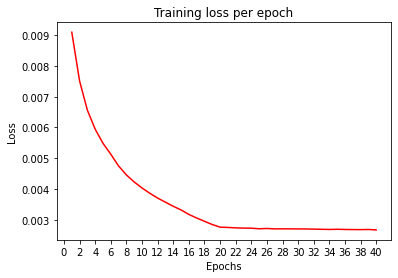

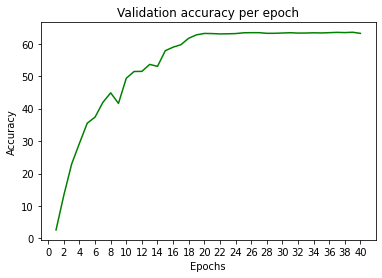

In [10]:
epochs = range(1, TRAINING_NUM_EPOCHS+1)

plt.plot(epochs, train_loss, 'r')
plt.title('Training loss per epoch')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, TRAINING_NUM_EPOCHS+1, step=2))
plt.ylabel('Loss')
plt.show()

plt.plot(epochs, train_acc, 'g')
plt.title('Validation accuracy per epoch')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, TRAINING_NUM_EPOCHS+1, step=2))
plt.ylabel('Accuracy')
plt.show()

In [12]:
# initialize test state
model.eval()
test_correct = 0
test_total   = 0

# initialize class stats
class_correct = list(0. for i in range(DATA_NUM_CLASSES))
class_total   = list(0. for i in range(DATA_NUM_CLASSES))

print('Testing...')
# no gradient/weight update needed
with torch.no_grad():

    # cycle through the test set
    for data in dataloader_test:

        # extract a batch of data and move it to the appropriate device
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # forward pass
        outputs = model(inputs)

        # prediction
        _, predicted = torch.max(outputs.data, 1)

        # update test set stats
        test_total = test_total + labels.size(0)
        test_correct = test_correct + (predicted == labels).sum().item()

        # update class stats
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# test set stats
acc = 100.0*test_correct/test_total
print('Accuracy of test set = {0:5.2f}%'.format(acc))
print('')

# class stats
print('Class accuracy:')
for i in range(len(DATA_CLASS_NAMES)):
    acc = 100.0*class_correct[i]/class_total[i]
    print('Accuracy of {0:5s} = {1:5.2f}'.format(DATA_CLASS_NAMES[i], acc))

Testing...
Accuracy of test set = 63.22%

Class accuracy:
Accuracy of plane = 82.00
Accuracy of car   = 70.00
Accuracy of bird  = 66.00
Accuracy of cat   = 68.00
Accuracy of deer  = 54.00
Accuracy of dog   = 48.00
Accuracy of frog  = 58.00
Accuracy of horse = 48.00
Accuracy of ship  = 94.00
Accuracy of truck = 64.00
